## Define problem

In [2]:
NZ=2801; NX=13601
H=1.25
#crop out water column
NZ_CROP=2396

#on space
#vmin=300
fpeak=3
#lambda_min=vmin/(2*fpeak)=50
h=10  #50/h=10
sig=9.6  #0.48/(0.5/h)

nz=151  #1501 km
nx=1701


#on time
vmax=3550
dt=0.00169 #=0.6*h/vmax
#T=11.3328 sec
nt=6800

ntr=1700

#How good initial model do you want?
siginit=250

In [3]:
import numpy as np
import matplotlib.pyplot as plt

z=np.arange(0,nz)*h
x=np.arange(0,nx)*h

def read(filename,n=(nx,nz)):
    return np.fromfile(filename,dtype='float32').reshape(n).T

def read_su(filename,n=(ntr,nt)):
    data=read(filename,n=(n[0],int(60+n[1])))
    return data[60:,:]

def imshow(data,perc=None,clip=None,clipmin=None,extent=None,cmap='viridis',title=None,title_colorbar=None,grid=True):
    if perc==None:
        clipp=[np.amin(data),np.amax(data)]
    else:
        tmp=np.percentile(np.abs(data),q=perc)
        clipp=[-tmp,tmp]
    
    if clip!=None: clipp=clip
    
    if clipmin!=None: clipp[0]=clipmin
    
    plt.imshow(data,vmin=clipp[0],vmax=clipp[1],cmap=cmap,extent=extent,aspect='auto')
    cbar=plt.colorbar(location='right')
    cbar=cbar.ax.set_ylabel(title_colorbar)
    if grid==True: plt.grid(visible=grid, axis='both', which='both', color='w', linestyle='--',linewidth=0.5)
    #plt.xlabel(labels[0]); plt.ylabel(labels[1])
    if title!=None: plt.title(title)

In [4]:
##code
#!(cd ../../ ; git pull ; git checkout teaching ; make prepare)
#!(cd ../../FWD ; make cleanall ; make)
#!(cd ../../FWI ; make cleanall ; make)
!gfortran smoothgauss2dfast_zhou.f90 -o smoothgauss2dfast_zhou
!gfortran set_vmax.f90 -o set_vmax

In [21]:
#clone model
#!wget https://s3.amazonaws.com/open.source.geoscience/open_data/elastic-marmousi/elastic-marmousi-model.tar.gz #https://wiki.seg.org/wiki/AGL_Elastic_Marmousi
#!tar -xvzf elastic-marmousi-model.tar.gz
#!(cd ./elastic-marmousi-model/model/ ; for fi in `ls *.tar.gz`; do tar -xvzf $$fi; done)
!segyread tape=./elastic-marmousi-model/model/MODEL_P-WAVE_VELOCITY_1.25m.segy | sustrip > vp.bin
!segyread tape=./elastic-marmousi-model/model/MODEL_S-WAVE_VELOCITY_1.25m.segy | sustrip > vs.bin

3200+0 records in
6+1 records out
3200 bytes (3.2 kB, 3.1 KiB) copied, 0.0039191 s, 817 kB/s
n1=2801 n2=13601 d1=0.001250
nt=2801 ntr=13601 dt=0.001250
ns=2801
3200+0 records in
6+1 records out
3200 bytes (3.2 kB, 3.1 KiB) copied, 0.00720486 s, 444 kB/s
n1=2801 n2=13601 d1=0.001250
nt=2801 ntr=13601 dt=0.001250
ns=2801
3200+0 records in
6+1 records out
3200 bytes (3.2 kB, 3.1 KiB) copied, 0.00592368 s, 540 kB/s
n1=2801 n2=13601 d1=0.001250
nt=2801 ntr=13601 dt=0.001250
ns=2801


In [7]:
#smooth & resample the models
!make model

#make initial model
!make init

makevel v000=1 nz=151 nx=1701 > one
cat vp.10m vs.10m one  > true
echo 'Model Done!'
Model Done!
#ximage < true n1=151 d1=10 d2=10 title=true wclip=1028 bclip=4700 cmap=hsv6 legend=1 &
#ximage < init n1=151 d1=10 d2=10 title=init wclip=1028 bclip=4700 cmap=hsv6 legend=1 &
make: 'init' is up to date.


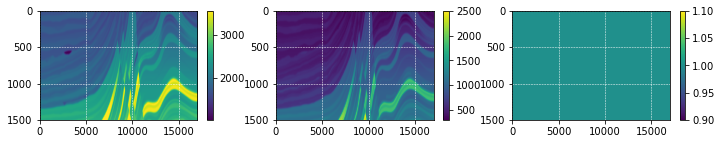

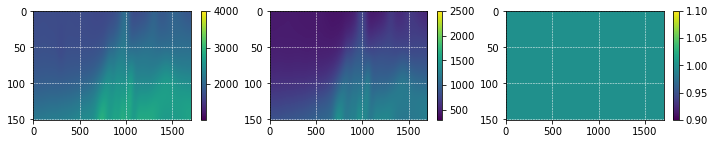

In [5]:
#plot
plt.figure(figsize=(12,2))
true=read('true',(3*nx,nz))
plt.subplot(1,3,1); imshow(true[:,:nx],extent=(0,(nx-1)*h,(nz-1)*h,0))
plt.subplot(1,3,2); imshow(true[:,nx:2*nx],clip=[300,2500],extent=(0,(nx-1)*h,(nz-1)*h,0))
plt.subplot(1,3,3); imshow(true[:,2*nx:],extent=(0,(nx-1)*h,(nz-1)*h,0))

plt.figure(figsize=(12,2))
init=read('init',(3*nx,nz))
plt.subplot(1,3,1); imshow(init[:,:nx],clip=[1028,4000])
plt.subplot(1,3,2); imshow(init[:,nx:2*nx],clip=[300,2500])
plt.subplot(1,3,3); imshow(init[:,2*nx:])

### more functions

In [6]:
def imshow_overlay(data1,data2,alpha=0.6,data1perc=None,data2perc=None,data1clip=None,data2clip=None,
                   cmap1='seismic',cmap2='gray',
                   extent=None,title=None,grid=True):
    if data1perc==None:
        clipp1=[np.amin(data1),np.amax(data1)]
    else:
        tmp=np.percentile(np.abs(data1),q=data1perc)
        clipp1=[-tmp,tmp]
    if data2perc==None:
        clipp2=[np.amin(data2),np.amax(data2)]
    else:
        tmp=np.percentile(np.abs(data2),q=data2perc)
        clipp2=[-tmp,tmp]
    
    if data1clip!=None: clipp1=data1clip
    if data2clip!=None: clipp2=data2clip
        
    plt.imshow(data1,vmin=clipp1[0],vmax=clipp1[1],            cmap=cmap1,extent=extent,aspect='auto')
    plt.imshow(data2,vmin=clipp2[0],vmax=0        ,alpha=alpha,cmap=cmap2,extent=extent,aspect='auto')
    
    #plt.colorbar(location='right')
    if grid==True: plt.grid(visible=grid, axis='both', which='both', color='y', linestyle='--',linewidth=0.5)
    #plt.xlabel(labels[0]); plt.ylabel(labels[1])
    if title!=None: plt.title(title)

def hilb_env(data):
    return np.abs(signal.hilbert(data,axis=0))

def normalize(data):
    out=np.zeros_like(data)
    amax=np.nanmax(data,axis=0)
    for i in range(amax.size):
        out[:,i]=data[:,i]/amax[i]
    return out
    
def amp_spec(data,axis=0):
    return np.abs(np.fft.rfft(data,axis=axis))

def smooth(data,sigma=(2,8)):
    return gaussian_filter(data,sigma=sigma)

def lat_avg(data):
    return np.mean(data,axis=1)



def make_FWDrun(app='FWD',np=28,nthreads=1,tag='',resdir='results',
                setup_more=[]):
    #!rm -fr $resdir
    exe='~/Codes/GitHub/SeisJIMU/exe/'+app
    #!rm run.slm; touch run.slm
    str=f"run_{tag}.sh"; print('bash '+str)
    #!cp /run/user/1001/gvfs/sftp:host=10.146.1.203,user=wei.zhou/cpgpfs/home/wei.zhou/run-compute.slm   $str
    !rm run_{tag}.sh
    ##
    #!sed -i 's/SBATCH --nodes=1/SBATCH --nodes=2/g' $str
    #!sed -i 's/#SBATCH --ntasks-per-node=28/#SBATCH --ntasks-per-node=14/g' $str
    ##
    with open(f"run_{tag}.sh", "a") as f:
        f.write(f"ulimit -s unlimited\n")
        f.write(f"export OMP_NUM_THREADS={nthreads}\n")
        f.write(f"mkdir -p {resdir} \n"),
        f.write(f"\n\n")
        ##
        f.write(f"cp setup_default setup_{tag}\n")
        f.write(f"echo \"DIR_OUT             \'{resdir}\'\"                     >> setup_{tag} \n")
        for i in range(len(setup_more)): f.write(f"echo \"{setup_more[i]}\"     >> setup_{tag} \n")
        f.write(f"mpirun --oversubscribe -np  {np}  {exe}  setup_{tag} > {resdir}/out \n")
        f.write(f"\n\n")
        
def make_FWIrun(app='FWI',np=28,nthreads=1,tag='',resdir='results',
                setup_more=[]):
    #!rm -fr $resdir
    exe='~/Codes/GitHub/SeisJIMU/exe/'+app
    #!rm run.slm; touch run.slm
    str=f"run_{tag}.sh"; print('bash '+str)
    #!cp /run/user/1001/gvfs/sftp:host=10.146.1.203,user=wei.zhou/cpgpfs/home/wei.zhou/run-compute.slm   $str
    !rm run_{tag}.sh
    ##
    #!sed -i 's/SBATCH --nodes=1/SBATCH --nodes=2/g' $str
    #!sed -i 's/#SBATCH --ntasks-per-node=28/#SBATCH --ntasks-per-node=14/g' $str
    ##
    with open(f"run_{tag}.sh", "a") as f:
        f.write(f"ulimit -s unlimited\n")
        f.write(f"export OMP_NUM_THREADS={nthreads}\n")
        f.write(f"mkdir -p {resdir} \n"),
        f.write(f"\n\n")
        ##
        f.write(f"cp setup_default setup_{tag}\n")
        f.write(f"echo \"DIR_OUT             \'{resdir}\'\"                     >> setup_{tag} \n")
        for i in range(len(setup_more)): f.write(f"echo \"{setup_more[i]}\"     >> setup_{tag} \n")
        f.write(f"mpirun --oversubscribe -np  {np}  {exe}  setup_{tag} > {resdir}/out \n")
        f.write(f"\n\n")

In [7]:
#!lda = rho(vp^2-2vs^2)
#!mu  = rho*vs^2
#!rho0= rho
#!gvp = glda*2rho*vp
#!gvs = (glda*-2 + gmu)*2rho*vs
#!grho= glda*vp^2 + (-2glda+gmu)*vs^2 + grho0
vp=init[:,:nx]
vs=init[:,nx:2*nx]
rho=1.
def gvp(glda):     return  glda            *2*rho*vp
def gvs(glda,gmu): return (glda*(-2) + gmu)*2*rho*vs

In [8]:
z=np.arange(0,nz)*h
zpow=np.power(z,1)
zpow=np.tile(zpow,(nx,1)).T

## Observed data

In [13]:
!cp setup_default setup
!echo "DIR_OUT         './resVS_obs' " >> setup
!echo "FS              '  0  1000  0'" >>setup
!echo "DS              '  0  7000  0'" >>setup
!echo "NS              2"  >>setup
!echo "SCOMP           vz" >> setup
!echo "RCOMP       'vz vx'" >> setup
!rm -r ./resVS_obs
!export OMP_NUM_THREADS=8; ulimit -s unlimited; mpirun -np 1 ../../exe/fwd_PSV_FDSG_O4_ setup #0.28min for 1shot

 MPIWorld info:
  MPI_INIT_THREAD level:           0
  Number of MPI processors:           1
  Max number of OMP threads / processor:           8
 Working directory: (pwd)
/home/wzhou/Codes/GitHub/SeisJIMU/Demo/11_FWI_DAS_ShallowMarm
 Using executable: (ls -l $exe)
-rwxrwxr-x 1 wzhou wzhou 630168 Dec 18 17:13 ../../exe/fwd_PSV_FDSG_O4_
 Git Commit: 40d6dfe
 Git Branch: DAS
 Compiler: gfortran v11.4.0
 Version: 11.4.0
 Endianness:         1234
 System date: 12/19/2023
System time: 15:37:57
System timezone: +03:00
                        
   WELCOME TO SeisJIMU FWD MODELING   
 Setup file: setup
 DIR_IN is NOT found, take default: ./
 Input directory: ./
 DIR_OUT : ./resVS_obs
 Output directory:./resVS_obs/
 Invoked field & propagator modules info : 
Time-domain ISOtropic 2D P-SV (ELastic) propagation
1st-order Velocity-Stress formulation
Vireux-Levandar Staggered-Grid Finite-Difference (FDSG) method
Cartesian O(x⁴,t²) stencil
CFL = Σ|coef| *Vmax *dt /rev_cell_diagonal
   -> dt ≤ 0.606 *

 it----         500
 fld_u minmax values:  -7.82614188E-06   8.34734328E-06
 it----        1000
 fld_u minmax values:  -6.91424248E-06   6.07133688E-06
 it----        1500
 fld_u minmax values:  -5.87223849E-06   5.09099254E-06
 it----        2000
 fld_u minmax values:  -6.06922003E-06   3.78218897E-06
 it----        2500
 fld_u minmax values:  -4.96084203E-06   4.23401661E-06
 it----        3000
 fld_u minmax values:  -4.39645737E-06   4.90082903E-06
 it----        3500
 fld_u minmax values:  -2.88067622E-06   4.04434923E-06
 it----        4000
 fld_u minmax values:  -3.32156014E-06   3.92727679E-06
 it----        4500
 fld_u minmax values:  -3.86473448E-06   3.55737939E-06
 it----        5000
 fld_u minmax values:  -3.32127092E-06   2.69406155E-06
 it----        5500
 fld_u minmax values:  -2.62069921E-06   2.39821065E-06
 it----        6000
 fld_u minmax values:  -2.18964647E-06   2.17723596E-06
 it----        6500
 fld_u minmax values:  -2.09144559E-06   2.42960346E-06
 Elapsed tim

In [14]:
!cp setup_default setup
!echo "DIR_OUT         './res_obs' " >> setup
!echo "FS              '  0  1000  0'" >>setup
!echo "DS              '  0  7000  0'" >>setup
!echo "NS              2" >>setup
!echo "SCOMP          pz" >> setup
!echo "RCOMP   'pz px ex'" >> setup
!rm -r ./res_obs
!export OMP_NUM_THREADS=8; ulimit -s unlimited; mpirun -np 1 ../../exe/FWD setup #0.42min for 1shot

 MPIWorld info:
  MPI_INIT_THREAD level:           0
  Number of MPI processors:           1
  Max number of OMP threads / processor:           8
 Working directory: (pwd)
/home/wzhou/Codes/GitHub/SeisJIMU/Demo/11_FWI_DAS_ShallowMarm
 Using executable: (ls -l $exe)
lrwxrwxrwx 1 wzhou wzhou 16 Dec 18 17:13 ../../exe/FWD -> fwd_DAS_FDSG_O4_
 Git Commit: 40d6dfe
 Git Branch: DAS
 Compiler: gfortran v11.4.0
 Version: 11.4.0
 Endianness:         1234
 System date: 12/19/2023
System time: 15:38:48
System timezone: +03:00
                        
   WELCOME TO SeisJIMU FWD MODELING   
 Setup file: setup
 DIR_IN is NOT found, take default: ./
 Input directory: ./
 DIR_OUT : ./res_obs
 Output directory:./res_obs/
 Invoked field & propagator modules info : 
Time-domain ISOtropic 2D P-SV (ELastic) propagation
1st-order Momemtum-Strain formulation
Vireux-Levandar Staggered-Grid Finite-Difference (FDSG) method
Cartesian O(x⁴,t²) stencil
CFL = Σ|coef| *Vmax *dt /rev_cell_diagonal
   -> dt ≤ 0.606 *V

 it----         500
 fld_u minmax values:  -7.82614279E-06   8.34734237E-06
 it----        1000
 fld_u minmax values:  -6.91424384E-06   6.07133734E-06
 it----        1500
 fld_u minmax values:  -5.87223803E-06   5.09099118E-06
 it----        2000
 fld_u minmax values:  -6.06921913E-06   3.78218942E-06
 it----        2500
 fld_u minmax values:  -4.96084112E-06   4.23401661E-06
 it----        3000
 fld_u minmax values:  -4.39645646E-06   4.90082903E-06
 it----        3500
 fld_u minmax values:  -2.88067554E-06   4.04434923E-06
 it----        4000
 fld_u minmax values:  -3.32155946E-06   3.92727770E-06
 it----        4500
 fld_u minmax values:  -3.86473630E-06   3.55737893E-06
 it----        5000
 fld_u minmax values:  -3.32127161E-06   2.69406155E-06
 it----        5500
 fld_u minmax values:  -2.62069943E-06   2.39821179E-06
 it----        6000
 fld_u minmax values:  -2.18964578E-06   2.17723505E-06
 it----        6500
 fld_u minmax values:  -2.09144537E-06   2.42960368E-06
 Elapsed tim

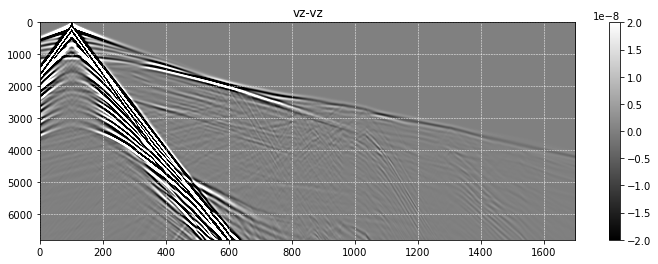

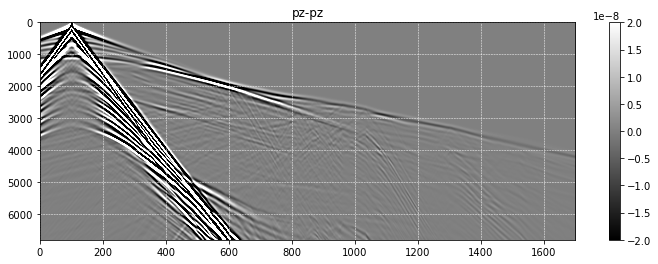

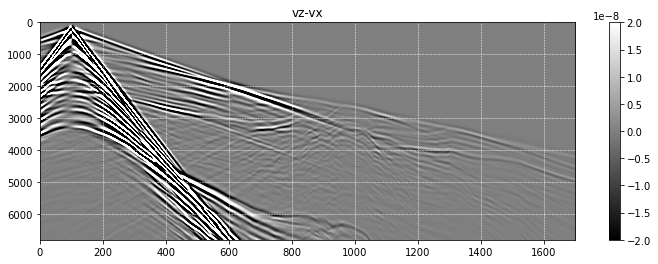

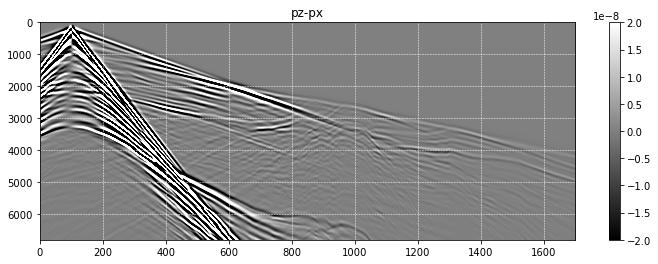

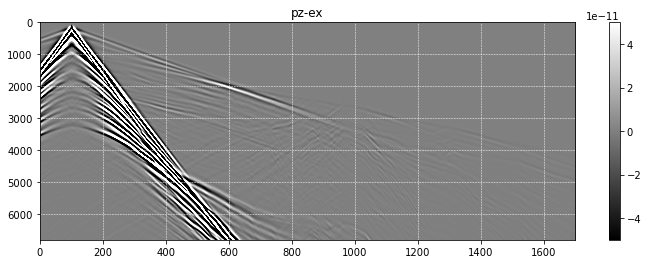

In [17]:
plt.figure(figsize=(12,4))
!suwind < resVS_obs/Ru_Shot0001.su key=trid min=12 max=12 > obs0001.su
imshow(read_su('obs0001.su'),clip=(-2e-8,2e-8),title='vz-vz',cmap='gray')

plt.figure(figsize=(12,4))
!suwind < res_obs/Ru_Shot0001.su key=trid min=32 max=32 > obs0001.su
imshow(read_su('obs0001.su'),clip=(-2e-8,2e-8),title='pz-pz',cmap='gray')

plt.figure(figsize=(12,4))
!suwind < resVS_obs/Ru_Shot0001.su key=trid min=14 max=14 > obs0001.su
imshow(read_su('obs0001.su'),clip=(-2e-8,2e-8),title='vz-vx',cmap='gray')

plt.figure(figsize=(12,4))
!suwind < res_obs/Ru_Shot0001.su key=trid min=34 max=34 > obs0001.su
imshow(read_su('obs0001.su'),clip=(-2e-8,2e-8),title='pz-px',cmap='gray')

plt.figure(figsize=(12,4))
!suwind < res_obs/Ru_Shot0001.su key=trid min=22 max=22 > obs0001.su
imshow(read_su('obs0001.su'),clip=(-5e-11,5e-11),title='pz-ex',cmap='gray')

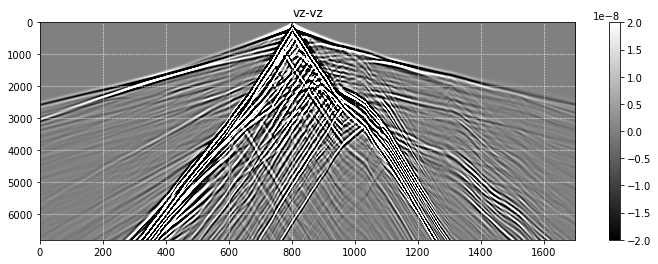

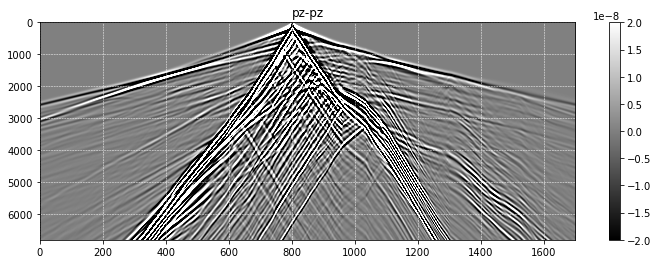

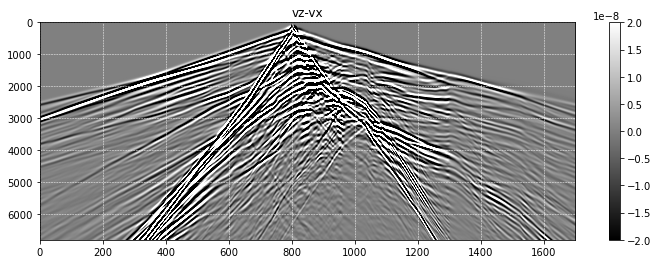

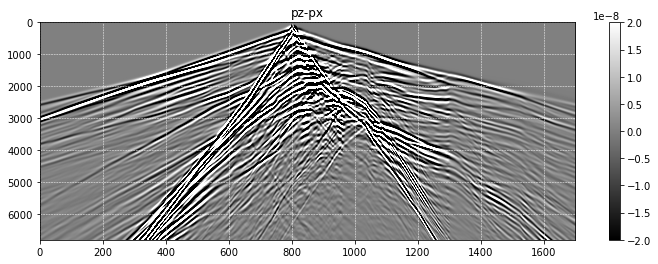

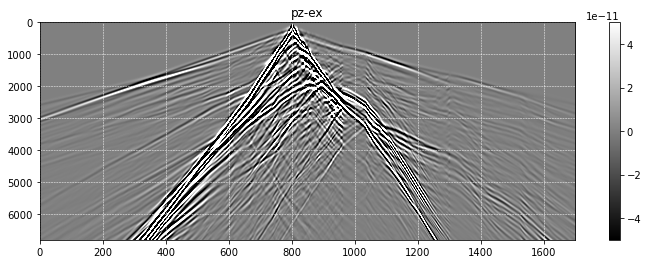

In [18]:
plt.figure(figsize=(12,4))
!suwind < resVS_obs/Ru_Shot0002.su key=trid min=12 max=12 > obs0002.su
imshow(read_su('obs0002.su'),clip=(-2e-8,2e-8),title='vz-vz',cmap='gray')

plt.figure(figsize=(12,4))
!suwind < res_obs/Ru_Shot0002.su key=trid min=32 max=32 > obs0002.su
imshow(read_su('obs0002.su'),clip=(-2e-8,2e-8),title='pz-pz',cmap='gray')

plt.figure(figsize=(12,4))
!suwind < resVS_obs/Ru_Shot0002.su key=trid min=14 max=14 > obs0002.su
imshow(read_su('obs0002.su'),clip=(-2e-8,2e-8),title='vz-vx',cmap='gray')

plt.figure(figsize=(12,4))
!suwind < res_obs/Ru_Shot0002.su key=trid min=34 max=34 > obs0002.su
imshow(read_su('obs0002.su'),clip=(-2e-8,2e-8),title='pz-px',cmap='gray')

plt.figure(figsize=(12,4))
!suwind < res_obs/Ru_Shot0002.su key=trid min=22 max=22 > obs0002.su
imshow(read_su('obs0002.su'),clip=(-5e-11,5e-11),title='pz-ex',cmap='gray')

## two-shot Gradient

In [19]:
!cp setup_default setup
!echo "DIR_OUT             './res_grad_pz-pz' " >> setup; rm -r ./res_grad_pz-pz
!echo "FILE_MODEL          'init'" >> setup
!rm obs0001.su; suwind < res_obs/Ru_Shot0001.su key=trid min=32 max=32 > obs0001.su
!rm obs0002.su; suwind < res_obs/Ru_Shot0002.su key=trid min=32 max=32 > obs0002.su
!echo "FILE_DATA_PREFIX     obs" >> setup
!echo "NBATCH                 2" >> setup
#!export OMP_NUM_THREADS=8; ulimit -s unlimited; mpirun -np 1 ../../exe/FWI setup  #1.3min for 1shot

 MPIWorld info:
  MPI_INIT_THREAD level:           0
  Number of MPI processors:           1
  Max number of OMP threads / processor:           8
 Working directory: (pwd)
/home/wzhou/Codes/GitHub/SeisJIMU/Demo/11_FWI_DAS_ShallowMarm
 Using executable: (ls -l $exe)
lrwxrwxrwx 1 wzhou wzhou 45 Dec 18 17:13 ../../exe/FWI -> fwi_DAS_FDSG_O4_velocities-density_Wolfe_NLCG
 Git Commit: 40d6dfe
 Git Branch: DAS
 Compiler: gfortran v11.4.0
 Version: 11.4.0
 Endianness:         1234
 System date: 12/19/2023
System time: 15:41:36
System timezone: +03:00
                        
       WELCOME TO SeisJIMU FWI        
 Setup file: setup
 DIR_IN is NOT found, take default: ./
 Input directory: ./
 DIR_OUT : ./res_grad_pz-pz
 Output directory:./res_grad_pz-pz/
 Invoked field & propagator modules info : 
Time-domain ISOtropic 2D P-SV (ELastic) propagation
1st-order Momemtum-Strain formulation
Vireux-Levandar Staggered-Grid Finite-Difference (FDSG) method
Cartesian O(x⁴,t²) stencil
CFL = Σ|coef| *Vmax

 ----  Computing obj func & dadj  ----
 WEIGHTING (WEI) : none
 WEIGHTING_OPERATIONS (WEI_OP) is NOT found, take default: multiply
 SU data write success.
 DATA_NORM (DNORM) is NOT found, take default: L2
 SU data write success.
 ----  Solving adjoint eqn & xcorrelate  ----
 it----        6500
 fld_a minmax values:  -5.45452628E-10   6.89405921E-10
 fld_u minmax values:  -2.62375056E-06   1.89183402E-06
 it----        6000
 fld_a minmax values:  -1.11422938E-09   1.30047972E-09
 fld_u minmax values:  -3.43584111E-06   2.51261577E-06
 it----        5500
 fld_a minmax values:  -1.71821368E-09   1.83907634E-09
 fld_u minmax values:  -4.16480043E-06   3.45624062E-06
 it----        5000
 fld_a minmax values:  -1.73651304E-09   1.51590596E-09
 fld_u minmax values:  -4.68650478E-06   3.74026922E-06
 it----        4500
 fld_a minmax values:  -1.78345638E-09   1.41410550E-09
 fld_u minmax values:  -4.86178624E-06   4.21587038E-06
 it----        4000
 fld_a minmax values:  -1.88293448E-09   1.45

 it----        3500
 fld_a minmax values:  -1.36537015E-09   1.36187361E-09
 fld_u minmax values:  -4.87214857E-06   4.51402320E-06
 it----        3000
 fld_a minmax values:  -1.72149661E-09   1.60421754E-09
 fld_u minmax values:  -3.97363920E-06   3.75038690E-06
 it----        2500
 fld_a minmax values:  -2.14794760E-09   1.85064919E-09
 fld_u minmax values:  -3.21969515E-06   3.24930807E-06
 it----        2000
 fld_a minmax values:  -2.63735700E-09   2.25047825E-09
 fld_u minmax values:  -3.01668774E-06   3.36189737E-06
 it----        1500
 fld_a minmax values:  -3.29446070E-09   2.42391729E-09
 fld_u minmax values:  -3.31371962E-06   3.64866628E-06
 it----        1000
 fld_a minmax values:  -3.96930178E-09   2.43747356E-09
 fld_u minmax values:  -3.43936381E-06   4.26789984E-06
 it----         500
 fld_a minmax values:  -5.75328452E-09   4.29607772E-09
 fld_u minmax values:  -4.97506744E-06   6.55200029E-06
 Elapsed time to load boundary              0.692871094    
 Elapsed time to

In [17]:
!cp setup_default setup
!echo "DIR_OUT             './res_grad_vz-vx' " >> setup; rm -r ./res_grad_vz-vx
!echo "FILE_MODEL          'init'" >> setup
!rm obs0001.su; suwind < resVS_obs/Ru_Shot0001.su key=trid min=14 max=14 > obs0001.su
!rm obs0002.su; suwind < resVS_obs/Ru_Shot0002.su key=trid min=14 max=14 > obs0002.su
!echo "FILE_DATA_PREFIX     obs" >> setup
!echo "NBATCH                 2" >> setup
!echo "SCOMP                 vz" >> setup
!echo "RCOMP                 vx" >> setup
#!export OMP_NUM_THREADS=8; ulimit -s unlimited; mpirun -np 1 ../../exe/fwi_PSV_FDSG_O4_velocities-density_Wolfe_NLCG setup
#0.3+0.8min for 1shot

Authorization required, but no authorization protocol specified
 MPIWorld info:
  MPI_INIT_THREAD level:           0
  Number of MPI processors:           1
  Max number of OMP threads / processor:           8
 Working directory: (pwd)
/home/wzhou/Codes/GitHub/SeisJIMU/Demo/11_FWI_DAS_ShallowMarm
 Using executable: (ls -l $exe)
-rwxrwxr-x 1 wzhou wzhou 949872 Dec 18 17:12 ../../exe/fwi_PSV_FDSG_O4_velocities-density_Wolfe_NLCG
 Git Commit: 40d6dfe
 Git Branch: DAS
 Compiler: gfortran v11.4.0
 Version: 11.4.0
 Endianness:         1234
 System date: 12/19/2023
System time: 16:10:30
System timezone: +03:00
                        
       WELCOME TO SeisJIMU FWI        
 Setup file: setup
 DIR_IN is NOT found, take default: ./
 Input directory: ./
 DIR_OUT : ./res_grad_vz-vx
 Output directory:./res_grad_vz-vx/
 Invoked field & propagator modules info : 
Time-domain ISOtropic 2D P-SV (ELastic) propagation
1st-order Velocity-Stress formulation
Vireux-Levandar Staggered-Grid Finite-Difference

 SU data write success.
 JOB : gradient
 IF_BLOOM is NOT found, take default: T
 ----  Computing obj func & dadj  ----
 WEIGHTING (WEI) : none
 WEIGHTING_OPERATIONS (WEI_OP) is NOT found, take default: multiply
 SU data write success.
 DATA_NORM (DNORM) is NOT found, take default: L2
 SU data write success.
 ----  Solving adjoint eqn & xcorrelate  ----
 it----        6500
 fld_a minmax values:  -2.48281118E-11   2.66128022E-11
 fld_u minmax values:  -2.62375033E-06   1.89183379E-06
 it----        6000
 fld_a minmax values:  -4.49990219E-11   5.34626544E-11
 fld_u minmax values:  -3.43584225E-06   2.51261622E-06
 it----        5500
 fld_a minmax values:  -8.58078816E-11   9.04590569E-11
 fld_u minmax values:  -4.16480134E-06   3.45624085E-06
 it----        5000
 fld_a minmax values:  -1.32130626E-10   1.59993699E-10
 fld_u minmax values:  -4.68650660E-06   3.74027036E-06
 it----        4500
 fld_a minmax values:  -1.76259896E-10   2.15626128E-10
 fld_u minmax values:  -4.86178124E-06   

 it----        4000
 fld_a minmax values:  -5.60939524E-11   5.67090021E-11
 fld_u minmax values:  -2.66805500E-06   2.21451251E-06
 it----        3500
 fld_a minmax values:  -1.57990857E-10   1.65350594E-10
 fld_u minmax values:  -4.87214629E-06   4.51402093E-06
 it----        3000
 fld_a minmax values:  -1.68067130E-10   2.11107659E-10
 fld_u minmax values:  -3.97364147E-06   3.75038962E-06
 it----        2500
 fld_a minmax values:  -1.65038747E-10   1.82315260E-10
 fld_u minmax values:  -3.21969742E-06   3.24930716E-06
 it----        2000
 fld_a minmax values:  -2.24193317E-10   1.49666779E-10
 fld_u minmax values:  -3.01668842E-06   3.36189669E-06
 it----        1500
 fld_a minmax values:  -2.21152319E-10   1.34319084E-10
 fld_u minmax values:  -3.31371825E-06   3.64866719E-06
 it----        1000
 fld_a minmax values:  -2.10646500E-10   1.53288396E-10
 fld_u minmax values:  -3.43936244E-06   4.26789984E-06
 it----         500
 fld_a minmax values:  -3.77565340E-10   2.87175117E-10


In [18]:
!cp setup_default setup
!echo "DIR_OUT             './res_grad_pz-px' " >> setup; rm -r ./res_grad_pz-px
!echo "FILE_MODEL          'init'" >> setup
!rm obs0001.su; suwind < res_obs/Ru_Shot0001.su key=trid min=34 max=34 > obs0001.su
!rm obs0002.su; suwind < res_obs/Ru_Shot0002.su key=trid min=34 max=34 > obs0002.su
!echo "FILE_DATA_PREFIX     obs" >> setup
!echo "NBATCH                 2" >> setup
!echo "RCOMP                 px" >> setup
#!export OMP_NUM_THREADS=8; ulimit -s unlimited; mpirun -np 1 ../../exe/FWI setup  #0.37+0.74min for 1shot

Authorization required, but no authorization protocol specified
 MPIWorld info:
  MPI_INIT_THREAD level:           0
  Number of MPI processors:           1
  Max number of OMP threads / processor:           8
 Working directory: (pwd)
/home/wzhou/Codes/GitHub/SeisJIMU/Demo/11_FWI_DAS_ShallowMarm
 Using executable: (ls -l $exe)
lrwxrwxrwx 1 wzhou wzhou 45 Dec 18 17:13 ../../exe/FWI -> fwi_DAS_FDSG_O4_velocities-density_Wolfe_NLCG
 Git Commit: 40d6dfe
 Git Branch: DAS
 Compiler: gfortran v11.4.0
 Version: 11.4.0
 Endianness:         1234
 System date: 12/19/2023
System time: 16:13:22
System timezone: +03:00
                        
       WELCOME TO SeisJIMU FWI        
 Setup file: setup
 DIR_IN is NOT found, take default: ./
 Input directory: ./
 DIR_OUT : ./res_grad_pz-px
 Output directory:./res_grad_pz-px/
 Invoked field & propagator modules info : 
Time-domain ISOtropic 2D P-SV (ELastic) propagation
1st-order Momemtum-Strain formulation
Vireux-Levandar Staggered-Grid Finite-Differe

 SU data write success.
 JOB : gradient
 IF_BLOOM is NOT found, take default: T
 ----  Computing obj func & dadj  ----
 WEIGHTING (WEI) : none
 WEIGHTING_OPERATIONS (WEI_OP) is NOT found, take default: multiply
 SU data write success.
 DATA_NORM (DNORM) is NOT found, take default: L2
 SU data write success.
 ----  Solving adjoint eqn & xcorrelate  ----
 it----        6500
 fld_a minmax values:  -2.48281048E-11   2.66128231E-11
 fld_u minmax values:  -2.62375056E-06   1.89183402E-06
 it----        6000
 fld_a minmax values:  -4.49990531E-11   5.34626683E-11
 fld_u minmax values:  -3.43584111E-06   2.51261577E-06
 it----        5500
 fld_a minmax values:  -8.58078886E-11   9.04590222E-11
 fld_u minmax values:  -4.16480043E-06   3.45624062E-06
 it----        5000
 fld_a minmax values:  -1.32130556E-10   1.59993463E-10
 fld_u minmax values:  -4.68650478E-06   3.74026922E-06
 it----        4500
 fld_a minmax values:  -1.76259951E-10   2.15626197E-10
 fld_u minmax values:  -4.86178624E-06   

 it----        4000
 fld_a minmax values:  -5.60940044E-11   5.67090923E-11
 fld_u minmax values:  -2.66805682E-06   2.21451114E-06
 it----        3500
 fld_a minmax values:  -1.57990857E-10   1.65350678E-10
 fld_u minmax values:  -4.87214857E-06   4.51402320E-06
 it----        3000
 fld_a minmax values:  -1.68067074E-10   2.11107645E-10
 fld_u minmax values:  -3.97363920E-06   3.75038690E-06
 it----        2500
 fld_a minmax values:  -1.65038733E-10   1.82315232E-10
 fld_u minmax values:  -3.21969515E-06   3.24930807E-06
 it----        2000
 fld_a minmax values:  -2.24193400E-10   1.49666779E-10
 fld_u minmax values:  -3.01668774E-06   3.36189737E-06
 it----        1500
 fld_a minmax values:  -2.21152305E-10   1.34319084E-10
 fld_u minmax values:  -3.31371962E-06   3.64866628E-06
 it----        1000
 fld_a minmax values:  -2.10646514E-10   1.53288465E-10
 fld_u minmax values:  -3.43936381E-06   4.26789984E-06
 it----         500
 fld_a minmax values:  -3.77565090E-10   2.87175034E-10


In [11]:
!cp setup_default setup
!echo "DIR_OUT             './res_grad_pz-ex' " >> setup; rm -r ./res_grad_pz-ex
!echo "FILE_MODEL          'init'" >> setup
!rm obs0001.su; suwind < res_obs/Ru_Shot0001.su key=trid min=22 max=22 > obs0001.su
!rm obs0002.su; suwind < res_obs/Ru_Shot0002.su key=trid min=22 max=22 > obs0002.su
!echo "FILE_DATA_PREFIX     obs" >> setup
!echo "NBATCH                 2" >> setup
#!export OMP_NUM_THREADS=8; ulimit -s unlimited; mpirun -np 1 ../../exe/FWI setup #0.44+1.05min for 1shot

Authorization required, but no authorization protocol specified
 MPIWorld info:
  MPI_INIT_THREAD level:           0
  Number of MPI processors:           1
  Max number of OMP threads / processor:           8
 Working directory: (pwd)
/home/wzhou/Codes/GitHub/SeisJIMU/Demo/11_FWI_DAS_ShallowMarm
 Using executable: (ls -l $exe)
lrwxrwxrwx 1 wzhou wzhou 45 Dec 18 17:13 ../../exe/FWI -> fwi_DAS_FDSG_O4_velocities-density_Wolfe_NLCG
 Git Commit: 40d6dfe
 Git Branch: DAS
 Compiler: gfortran v11.4.0
 Version: 11.4.0
 Endianness:         1234
 System date: 12/19/2023
System time: 16:01:15
System timezone: +03:00
                        
       WELCOME TO SeisJIMU FWI        
 Setup file: setup
 DIR_IN is NOT found, take default: ./
 Input directory: ./
 DIR_OUT : ./res_grad_pz-ex
 Output directory:./res_grad_pz-ex/
 Invoked field & propagator modules info : 
Time-domain ISOtropic 2D P-SV (ELastic) propagation
1st-order Momemtum-Strain formulation
Vireux-Levandar Staggered-Grid Finite-Differe

 SU data write success.
 JOB : gradient
 IF_BLOOM is NOT found, take default: T
 ----  Computing obj func & dadj  ----
 WEIGHTING (WEI) : none
 WEIGHTING_OPERATIONS (WEI_OP) is NOT found, take default: multiply
 SU data write success.
 DATA_NORM (DNORM) is NOT found, take default: L2
 SU data write success.
 ----  Solving adjoint eqn & xcorrelate  ----
 it----        6500
 fld_a minmax values:  -1.27087301E-16   1.33035365E-16
 fld_u minmax values:  -2.62375056E-06   1.89183402E-06
 it----        6000
 fld_a minmax values:  -1.91934132E-16   2.17778801E-16
 fld_u minmax values:  -3.43584111E-06   2.51261577E-06
 it----        5500
 fld_a minmax values:  -3.60763032E-16   3.73177967E-16
 fld_u minmax values:  -4.16480043E-06   3.45624062E-06
 it----        5000
 fld_a minmax values:  -4.49617794E-16   5.92246072E-16
 fld_u minmax values:  -4.68650478E-06   3.74026922E-06
 it----        4500
 fld_a minmax values:  -5.86165381E-16   7.08284292E-16
 fld_u minmax values:  -4.86178624E-06   

 it----        4000
 fld_a minmax values:  -2.49110987E-16   2.55452246E-16
 fld_u minmax values:  -2.66805682E-06   2.21451114E-06
 it----        3500
 fld_a minmax values:  -5.98443230E-16   6.35535650E-16
 fld_u minmax values:  -4.87214857E-06   4.51402320E-06
 it----        3000
 fld_a minmax values:  -5.89024541E-16   7.23837140E-16
 fld_u minmax values:  -3.97363920E-06   3.75038690E-06
 it----        2500
 fld_a minmax values:  -5.74170707E-16   6.28336081E-16
 fld_u minmax values:  -3.21969515E-06   3.24930807E-06
 it----        2000
 fld_a minmax values:  -5.11802241E-16   4.57631520E-16
 fld_u minmax values:  -3.01668774E-06   3.36189737E-06
 it----        1500
 fld_a minmax values:  -4.46870231E-16   3.52452315E-16
 fld_u minmax values:  -3.31371962E-06   3.64866628E-06
 it----        1000
 fld_a minmax values:  -5.13166176E-16   4.40453162E-16
 fld_u minmax values:  -3.43936381E-06   4.26789984E-06
 it----         500
 fld_a minmax values:  -1.17855751E-15   8.47797130E-16


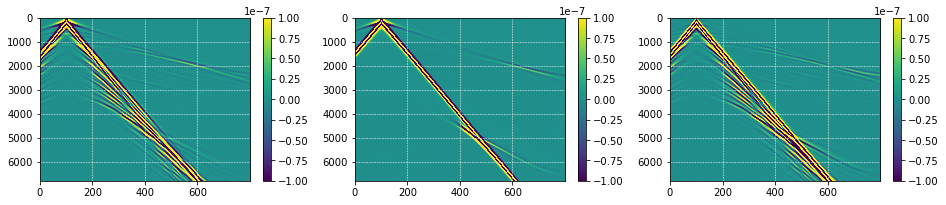

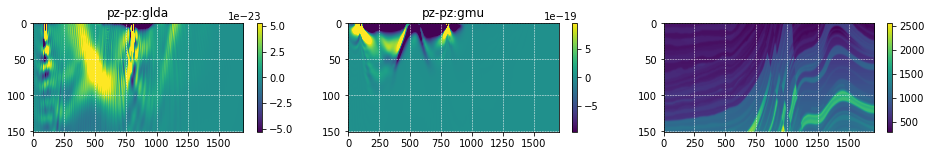

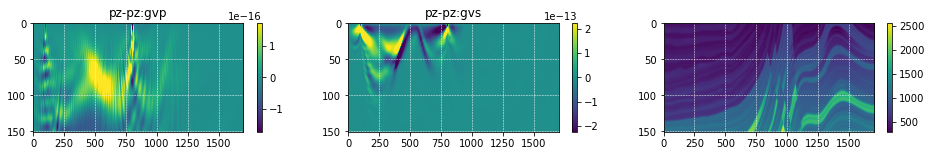

In [19]:
plt.figure(figsize=(16,3))
!suwind < res_obs/Ru_Shot0001.su key=trid min=32 max=32 > obs0001.su
plt.subplot(1,3,1); imshow(read_su('obs0001.su')[:,:800],clip=(-1e-7,1e-7))
plt.subplot(1,3,2); imshow(read_su('res_grad_pz-pz/Ru_Shot0001.su')[:,:800],clip=(-1e-7,1e-7))
plt.subplot(1,3,3); imshow((read_su('obs0001.su')
                           -read_su('res_grad_pz-pz/Ru_Shot0001.su'))[:,:800],clip=(-1e-7,1e-7))

grad=read('res_grad_pz-pz/correlate_gradient',n=(3*nx,nz))

plt.figure(figsize=(16,2))
plt.subplot(1,3,1); imshow(grad[:,nx:2*nx],perc=95,title='pz-pz:glda')
plt.subplot(1,3,2); imshow(grad[:,2*nx:],  perc=95,title='pz-pz:gmu')
plt.subplot(1,3,3); imshow(true[:,nx:2*nx])

plt.figure(figsize=(16,2))
plt.subplot(1,3,1); imshow(gvp(grad[:,nx:2*nx])*zpow,               perc=98,title='pz-pz:gvp')
plt.subplot(1,3,2); imshow(gvs(grad[:,nx:2*nx],grad[:,2*nx:])*zpow, perc=98,title='pz-pz:gvs')
plt.subplot(1,3,3); imshow(true[:,nx:2*nx])

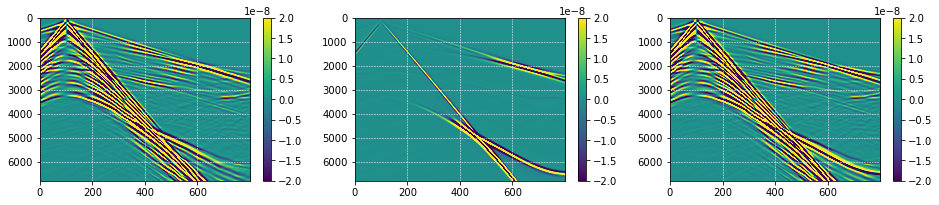

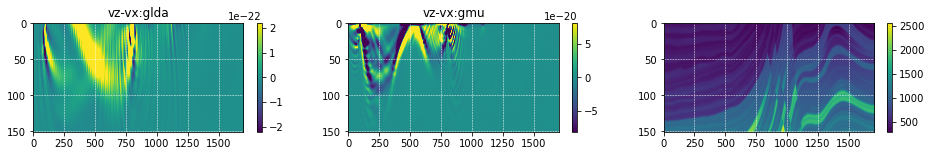

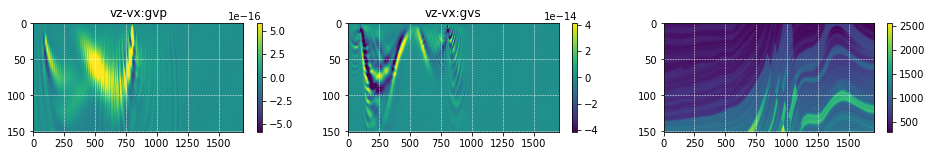

In [20]:
plt.figure(figsize=(16,3))
!suwind < resVS_obs/Ru_Shot0001.su key=trid min=14 max=14 > obs0001.su
plt.subplot(1,3,1); imshow(read_su('obs0001.su')[:,:800],clip=(-2e-8,2e-8))
plt.subplot(1,3,2); imshow(read_su('res_grad_vz-vx/Ru_Shot0001.su')[:,:800],clip=(-2e-8,2e-8))
plt.subplot(1,3,3); imshow((read_su('obs0001.su')
                           -read_su('res_grad_vz-vx/Ru_Shot0001.su'))[:,:800],clip=(-2e-8,2e-8))

grad=read('res_grad_vz-vx/correlate_gradient',n=(3*nx,nz))

plt.figure(figsize=(16,2))
plt.subplot(1,3,1); imshow(grad[:,nx:2*nx],perc=95,title='vz-vx:glda')
plt.subplot(1,3,2); imshow(grad[:,2*nx:],  perc=95,title='vz-vx:gmu')
plt.subplot(1,3,3); imshow(true[:,nx:2*nx])

plt.figure(figsize=(16,2))
plt.subplot(1,3,1); imshow(gvp(grad[:,nx:2*nx])*zpow,               perc=98,title='vz-vx:gvp')
plt.subplot(1,3,2); imshow(gvs(grad[:,nx:2*nx],grad[:,2*nx:])*zpow, perc=98,title='vz-vx:gvs')
plt.subplot(1,3,3); imshow(true[:,nx:2*nx])

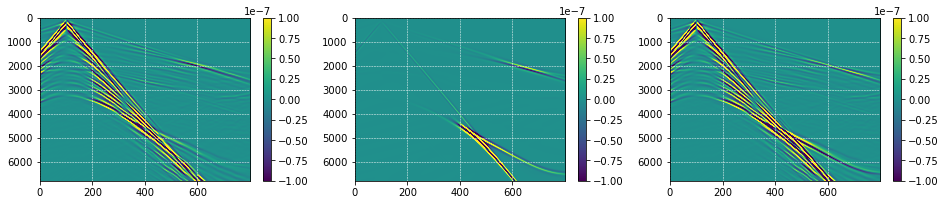

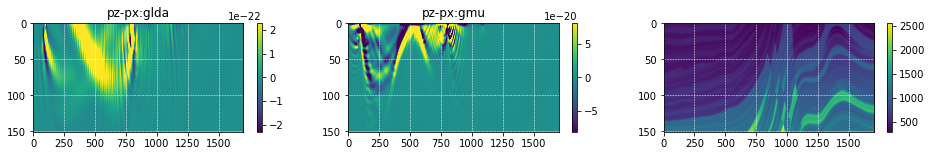

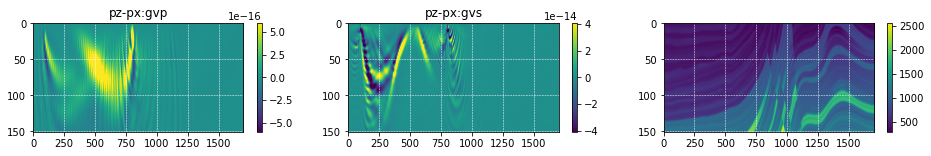

In [21]:
plt.figure(figsize=(16,3))
!suwind < res_obs/Ru_Shot0001.su key=trid min=34 max=34 > obs0001.su
plt.subplot(1,3,1); imshow(read_su('obs0001.su')[:,:800],clip=(-1e-7,1e-7))
plt.subplot(1,3,2); imshow(read_su('res_grad_pz-px/Ru_Shot0001.su')[:,:800],clip=(-1e-7,1e-7))
plt.subplot(1,3,3); imshow((read_su('obs0001.su')
                           -read_su('res_grad_pz-px/Ru_Shot0001.su'))[:,:800],clip=(-1e-7,1e-7))

grad=read('res_grad_pz-px/correlate_gradient',n=(3*nx,nz))

plt.figure(figsize=(16,2))
plt.subplot(1,3,1); imshow(grad[:,nx:2*nx],perc=95,title='pz-px:glda')
plt.subplot(1,3,2); imshow(grad[:,2*nx:],  perc=95,title='pz-px:gmu')
plt.subplot(1,3,3); imshow(true[:,nx:2*nx])

plt.figure(figsize=(16,2))
plt.subplot(1,3,1); imshow(gvp(grad[:,nx:2*nx])*zpow,               perc=98,title='pz-px:gvp')
plt.subplot(1,3,2); imshow(gvs(grad[:,nx:2*nx],grad[:,2*nx:])*zpow, perc=98,title='pz-px:gvs')
plt.subplot(1,3,3); imshow(true[:,nx:2*nx])

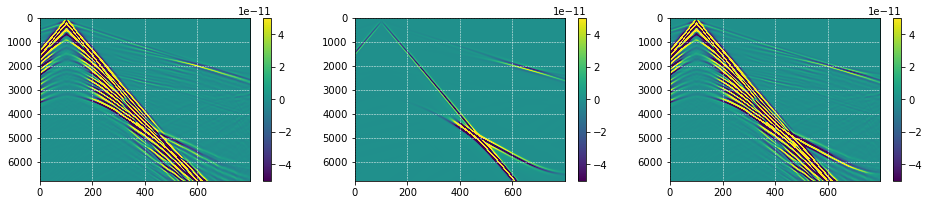

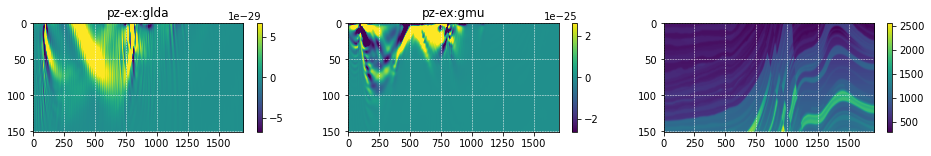

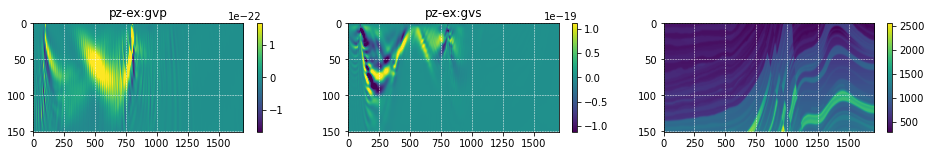

In [22]:
plt.figure(figsize=(16,3))
!suwind < res_obs/Ru_Shot0001.su key=trid min=22 max=22 > obs0001.su
plt.subplot(1,3,1); imshow(read_su('obs0001.su')[:,:800],clip=(-5e-11,5e-11))
plt.subplot(1,3,2); imshow(read_su('res_grad_pz-ex/Ru_Shot0001.su')[:,:800],clip=(-5e-11,5e-11))
plt.subplot(1,3,3); imshow((read_su('obs0001.su')
                           -read_su('res_grad_pz-ex/Ru_Shot0001.su'))[:,:800],clip=(-5e-11,5e-11))

grad=read('res_grad_pz-ex/correlate_gradient',n=(3*nx,nz))

plt.figure(figsize=(16,2))
plt.subplot(1,3,1); imshow(grad[:,nx:2*nx],perc=95,title='pz-ex:glda')
plt.subplot(1,3,2); imshow(grad[:,2*nx:],  perc=95,title='pz-ex:gmu')
plt.subplot(1,3,3); imshow(true[:,nx:2*nx])

plt.figure(figsize=(16,2))
plt.subplot(1,3,1); imshow(gvp(grad[:,nx:2*nx])*zpow,               perc=98,title='pz-ex:gvp')
plt.subplot(1,3,2); imshow(gvs(grad[:,nx:2*nx],grad[:,2*nx:])*zpow, perc=98,title='pz-ex:gvs')
plt.subplot(1,3,3); imshow(true[:,nx:2*nx])

## FWI iterations [later]

In [ ]:
ishot=1
#ishot=1:10:80
#ishot=1:20:144

!cp setup.in setup_fwi.in
!echo "DIR_OUT            './results_fwi' " >> setup_fwi.in
!echo "FILE_MODEL         init" >> setup_fwi.in
!echo "MODEL_ATTRIBUTES   vp" >> setup_fwi.in
!echo "ISHOT              '$(ishot)' " >> setup_fwi.in
!echo "SMOOTHING          Laplacian  " >> setup_fwi.in
!echo "JOB                optimization " >> setup_fwi.in
!rm -r ./results_fwi
!export OMP_NUM_THREADS=$(nthreads); ulimit -s unlimited; mpirun -np $(np) ../../exe/FWI setup_fwi.in > out_fwi

In [ ]:
plt.figure(figsize=(12,4))
plt.subplot(1,3,1); imshow(read_su('results_fwd/dsyn_Shot0001.su'),perc=98)
plt.subplot(1,3,2); imshow(read_su('results_fwi/dsyn_Shot0001.su'),perc=98)
plt.subplot(1,3,3); imshow(read_su('results_fwi/dadj_Shot0001.su'),perc=98)

plt.figure(figsize=(12,3))
plt.subplot(1,3,1); imshow(read('init'),clip=[1028,4700])
plt.subplot(1,3,2); imshow(read('results_fwi/model_final'),clip=[1028,4700])
plt.subplot(1,3,3); imshow(read('true')[:,:nx-1],clip=[1028,4700])